In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization,
    RandomFlip, RandomRotation, RandomZoom,
    RandomContrast, RandomBrightness,
    Rescaling, GlobalAveragePooling2D
)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory

# 1. إعدادات المسارات والمقاسات
DATA_DIR = r"C:\Users\baraa\Desktop\project\Alzheimer (Preprocessed Data)\Alzheimer (Preprocessed Data)"
IMAGE_SIZE = (224, 224) # مقاس ResNet50 القياسي
BATCH_SIZE = 32

# 2. تحميل بيانات التدريب
train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
   label_mode='categorical'

)

# 3. تحميل بيانات التحقق (Validation)
val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# 4. استخراج أسماء الفئات للتأكد
class_names = train_ds.class_names
print(f"الفئات الموجودة: {class_names}")
NUM_CLASSES = len(class_names)
print("عدد التصنيفات:", NUM_CLASSES)


Found 12776 files belonging to 4 classes.
Using 10221 files for training.
Found 12776 files belonging to 4 classes.
Using 2555 files for validation.
الفئات الموجودة: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
عدد التصنيفات: 4


In [2]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1),
    RandomBrightness(0.1)
])

# تطبيق التحسينات لتسريع القراءة من الذاكرة
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers # هذا السطر هو الحل لمشكلة NameError
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# 1. تحميل ResNet50 بأوزان ImageNet
base_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)

# 2. تجميد أول 100 طبقة وفتح الباقي للتعلم (Fine-tuning)
# هذا الجزء هو اللي بيخلي الدقة تطلع فوق الـ 50%
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

# 3. تجميع أجزاء النموذج
model = Sequential([
    data_augmentation,         
    layers.Rescaling(1./255),  
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),      
    Dropout(0.5),              
    Dense(NUM_CLASSES, activation='softmax')

])

# 4. إعداد عملية التعلم بمعدل تعلم صغير جداً
model.compile(
    optimizer=Adam(learning_rate=3e-5), 
     loss='categorical_crossentropy',
    metrics=['accuracy']
)
# عرض ملخص النموذج
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 19,452,928 (74.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# 1. إعداد المراقبين (Callbacks)
# التوقف المبكر: إذا لم يتحسن النموذج لـ 7 دورات سيتوقف التدريب ويأخذ أفضل نسخة
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=7, 
    restore_best_weights=True
)

# تقليل معدل التعلم: إذا ثبتت الدقة، سيقوم بتقليل "قوة التعلم" ليصبح النموذج أدق
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, # يقلل التعلم لـ 20% من قيمته
    patience=3, 
    min_lr=1e-7
)

# 2. بدء التدريب
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/25
320/320 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.5270 - loss: 1.2041 - val_accuracy: 0.6078 - val_loss: 0.8731 - learning_rate: 3.0000e-05
Epoch 2/25
320/320 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.6301 - loss: 0.8513 - val_accuracy: 0.7084 - val_loss: 0.6887 - learning_rate: 3.0000e-05
Epoch 3/25
320/320 ━━━━━━━━━━━━━━━━━━━━ 572s 2s/step - accuracy: 0.6646 - loss: 0.7623 - val_accuracy: 0.7053 - val_loss: 0.6483 - learning_rate: 3.0000e-05
Epoch 4/25
320/320 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.6830 - loss: 0.7141 - val_accuracy: 0.5155 - val_loss: 1.2254 - learning_rate: 3.0000e-05
Epoch 5/25
320/320 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.6988 - loss: 0.6792 - val_accuracy: 0.6990 - val_loss: 0.6688 - learning_rate: 3.0000e-05
Epoch 6/25
320/320 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.7114 - loss: 0.6554 - val_accuracy: 0.7593 - val_loss: 0.5330 - learning_rate: 3.0000e-05
Epoch 7/25
320/320 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - acc

KeyboardInterrupt: 

In [5]:
# حفظ النموذج بالصيغة الحديثة
model.save('alzheimer_resnet50_final2.keras')
print("Saved successfully in .keras format!")

Saved successfully in .keras format!


In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()


NameError: name 'history' is not defined

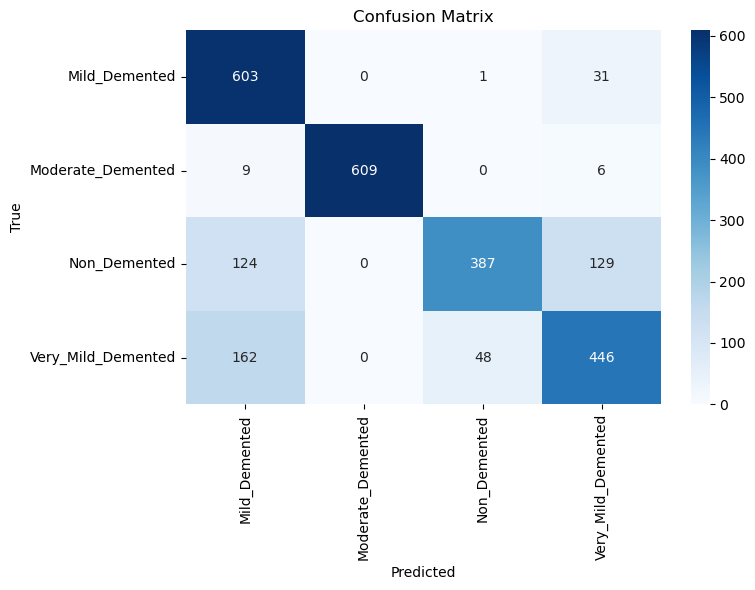


Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented     0.6715    0.9496    0.7867       635
 Moderate_Demented     1.0000    0.9760    0.9878       624
      Non_Demented     0.8876    0.6047    0.7193       640
Very_Mild_Demented     0.7288    0.6799    0.7035       656

          accuracy                         0.8004      2555
         macro avg     0.8220    0.8025    0.7993      2555
      weighted avg     0.8206    0.8004    0.7976      2555



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1) جمع الـ true والـ pred
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)  # (batch, 4)

    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2) Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# 3) Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
